In [1]:
import numpy as np
import os, sys
import importlib
from tqdm.notebook import tqdm, trange
import pandas as pd
import json
import itertools
from IPython.display import display

from FewShotTestHandler import FewShotTestHandler
from dataset import DatasetHandler
from similarity_metrics import Similarity
from plotting_utils import plot

ENV = os.environ["CONDA_DEFAULT_ENV"]

/home/rob/vlm_benchmark/FewShotTestHandler.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
params_dict = {}

# VLM Params - vlm.____ keys are passed into VLM constructor
if ENV == "VLM_CLIP":
    from CLIP.CLIPVLM import ClipVLM as VLM
    params_dict["vlm.num_frames"] = [1, 2, 4, 10]
elif ENV == "VLM_MILES":
    from MILES.wrapper import MILES_SimilarityVLM as VLM
elif ENV == "videoclip":
    from video_clip.video_clip import VideoClipVLM as VLM
    params_dict["vlm.num_seconds"] = [2, 4, 10]
    params_dict["vlm.sample_strat"] = ["spread"] #["center", "start", "spread"]
else:
    raise NotImplementedError

# Dataset Params - dataset.____ keys are passed into DatasetHandler constructor
params_dict["dataset.name"] = ["moma_act", "moma_sact", "kinetics_100"]
params_dict["dataset.split"] = ["test"]

# Classifier Params - classifier.____ keys are passed into classifier constructor
if True:
    from classifier import WeightedTextFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.metric"] = [Similarity.COSINE, Similarity.DOT, Similarity.EUCLID]
if False:
    from classifier import HardPromptFewShotClassifier as Classifier
    params_dict["classifier.text_weight"] = [0, 0.1, 1.0, 4.0, 10.0, 100.0]
    params_dict["classifier.prompt_text"] = [
        "",
        "a video of",
        "people doing",
        "how to",
        "what is",
        "people are",
        "looks like"
    ]
if False:
    from classifier import NearestNeighborFewShotClassifier as Classifier
    params_dict["classifier.neighbor_count"] = [1, 2, 3, 4, 5, 10, 20]
    params_dict["classifier.neighbor_weights"] = ["uniform", "distance"]

# Few-Shot Test Params - test.____ keys are passed into few-shot test call
params_dict["test.n_way"] = [5, 10, 20]
params_dict["test.n_support"] = [0, 1, 5, 10, 20]
params_dict["test.n_query"] = [4]
params_dict["test.n_episodes"] = [1000]

In [3]:
test_handler = FewShotTestHandler("param_test_results_2.csv")

In [4]:
vlm = None
cur_vlm_params = None
dataset = None
cur_dataset_params = None

pbar = tqdm(list(itertools.product(*params_dict.values())))
for params in pbar:
    # Associate keys to each param
    params = dict(zip(params_dict.keys(), params))
    
    pbar.set_postfix(params)
    
    # vlm params
    vlm_params = {key[4:]: val for key, val in params.items() if key.startswith("vlm.")}
    classifier_params = {key[11:]: val for key, val in params.items() if key.startswith("classifier.")}
    dataset_params = {key[8:]: val for key, val in params.items() if key.startswith("dataset.")}
    test_params = {key[5:]: val for key, val in params.items() if key.startswith("test.")}
    
    # Update vlm (which forces update of classifier)
    if vlm is None or cur_vlm_params != vlm_params:
        vlm = VLM(**vlm_params)
        cur_vlm_params = vlm_params
        
    # Update dataset (and fill vlm cache for new dataset)
    if dataset is None or cur_dataset_params != dataset_params:
        dataset = DatasetHandler(**dataset_params)
        cur_dataset_params = dataset_params
        test_handler.fill_cache(vlm, dataset)
        
    # Skip invalid combos of dataset and test parameters
    if not dataset.valid_for_few_shot(test_params["n_way"], test_params["n_support"], test_params["n_query"]):
        continue
    
    # Ensure 0-shot tests always set classifier.text_weight to 1
    if test_params["n_support"] == 0 and "text_weight" in classifier_params:
        classifier_params["text_weight"] = 1.0
    
    # Create classifier for this test (lightweight class, so no need to save over loop iterations)
    classifier = Classifier(vlm, **classifier_params)
    
    # Run test
    test_handler.run_few_shot_test(classifier, dataset, **test_params)

  0%|          | 0/2430 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.intermediate.dense.bias', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.8.intermediate.dense.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.7.attentio

dataset.moma.momaapi.lookup._read_anns() took 1.0612502098083496 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0006034374237060547 sec


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

dataset.moma.momaapi.lookup._read_anns() took 1.077523946762085 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0005805492401123047 sec


  0%|          | 0/3533 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.intermediate.dense.bias', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.8.intermediate.dense.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.7.attentio

dataset.moma.momaapi.lookup._read_anns() took 1.0491819381713867 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0005593299865722656 sec


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

dataset.moma.momaapi.lookup._read_anns() took 1.1309337615966797 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0005736351013183594 sec


  0%|          | 0/3533 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing MMBertForEncoder: ['bert.encoder.layer.11.attention.output.dense.weight', 'bert.encoder.layer.11.intermediate.dense.bias', 'bert.encoder.layer.6.attention.self.query.bias', 'bert.encoder.layer.8.attention.output.LayerNorm.bias', 'bert.encoder.layer.10.intermediate.dense.bias', 'bert.encoder.layer.6.output.dense.weight', 'bert.encoder.layer.8.intermediate.dense.weight', 'bert.encoder.layer.6.attention.self.key.bias', 'bert.encoder.layer.9.attention.self.query.weight', 'bert.encoder.layer.7.output.dense.weight', 'bert.encoder.layer.8.attention.output.LayerNorm.weight', 'bert.encoder.layer.10.attention.self.query.bias', 'bert.encoder.layer.10.attention.self.value.weight', 'bert.encoder.layer.7.attention.self.value.bias', 'bert.encoder.layer.10.intermediate.dense.weight', 'bert.encoder.layer.8.attention.self.value.bias', 'bert.encoder.layer.10.attention.self.key.weight', 'bert.encoder.layer.7.attentio

dataset.moma.momaapi.lookup._read_anns() took 1.0486421585083008 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0006670951843261719 sec


  0%|          | 0/261 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

dataset.moma.momaapi.lookup._read_anns() took 1.0562396049499512 sec
dataset.moma.momaapi.statistics._read_statistics() took 0.0006432533264160156 sec


  0%|          | 0/3533 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/transformers/modeling_utils.py:713: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/2400 [00:00<?, ?it/s]

/home/rob/miniconda3/envs/videoclip/lib/python3.8/site-packages/transformers/modeling_utils.py:713: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

### Plot Results

21 Overall Lines
7 Separate Plots


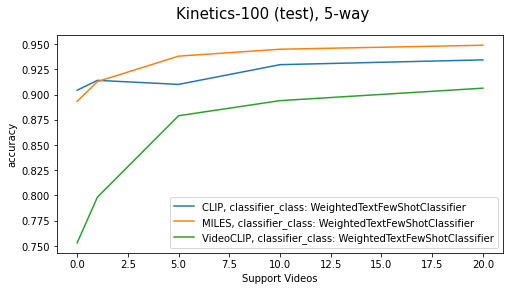

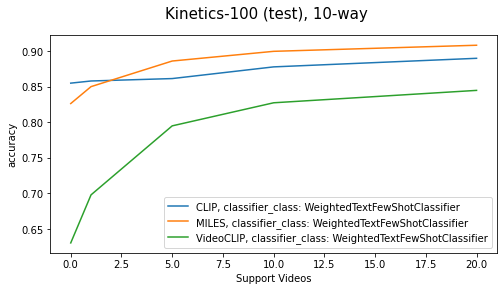

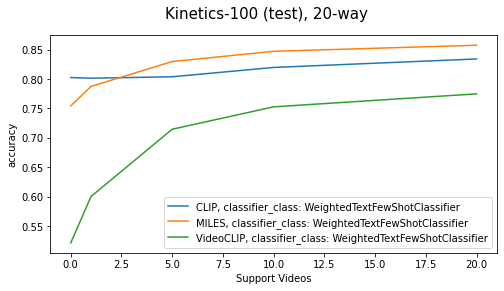

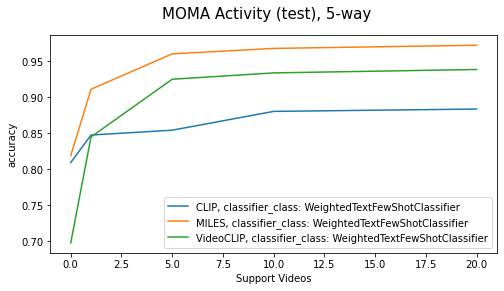

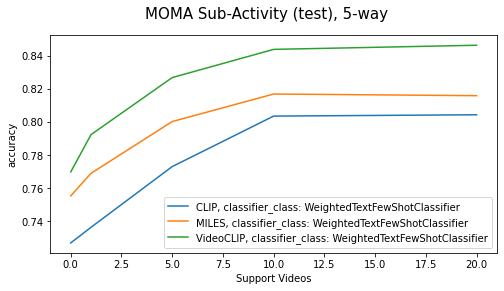

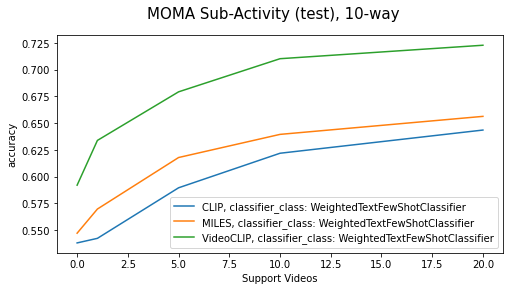

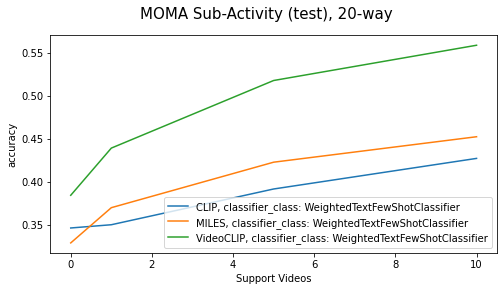

In [5]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way"],
    line_descriptor_cols=["vlm_class", "classifier_class"],
    agg_dict={
        "classifier.metric": max,
        "classifier.text_weight": max,
        "classifier.prompt_text": max,
        "classifier.neighbor_count": max,
        "classifier.neighbor_weights": max
    },
    filter_dict={
        # Specify particular versions of CLIP and VideoCLIP
        "vlm.num_frames": [1, np.nan],
        "vlm.num_seconds": [4, np.nan],
        "vlm.sample_strat": ["spread", "uniform", np.nan]
    }
)

In [6]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way", "vlm_class"],
    line_descriptor_cols=["classifier.prompt_text"],
    agg_dict={
        "classifier.metric": max,
        "classifier.text_weight": max
    },
    filter_dict={
        "classifier_class": "HardPromptFewShotClassifier",
        # Specify particular versions of CLIP and VideoCLIP
        "vlm.num_frames": [1, np.nan],
        "vlm.num_seconds": [4, np.nan],
        "vlm.sample_strat": ["spread", np.nan]
    }
)

0 Overall Lines


In [7]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way", "vlm_class", "classifier.neighbor_weights"],
    line_descriptor_cols=["classifier.neighbor_count"],
    agg_dict={
        "classifier.metric": max
    },
    filter_dict={
        "classifier_class": "NearestNeighborFewShotClassifier",
        # Specify particular versions of CLIP and VideoCLIP
        "vlm.num_frames": [1, np.nan],
        "vlm.num_seconds": [4, np.nan],
        "vlm.sample_strat": ["spread", np.nan]
    }
)

0 Overall Lines


21 Overall Lines
7 Separate Plots


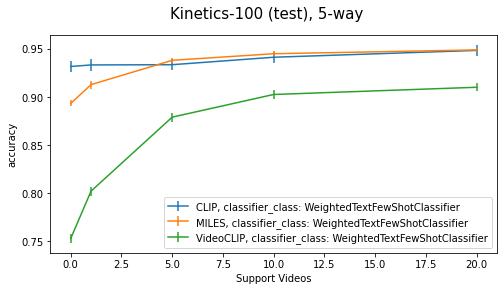

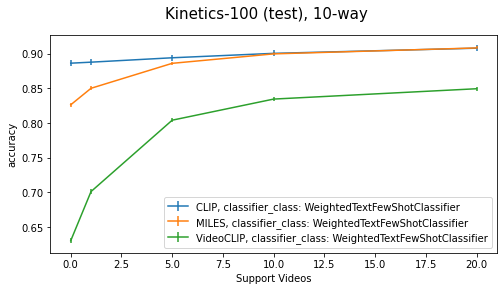

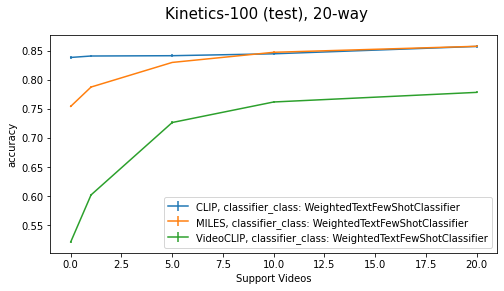

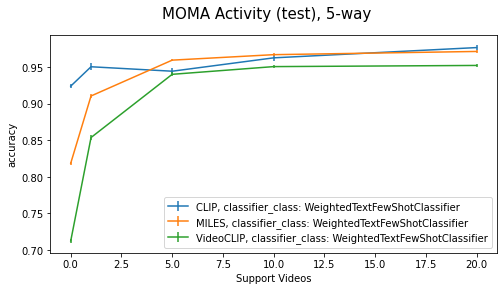

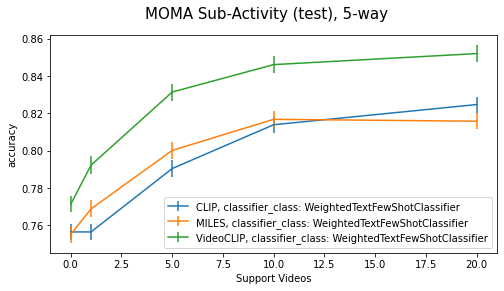

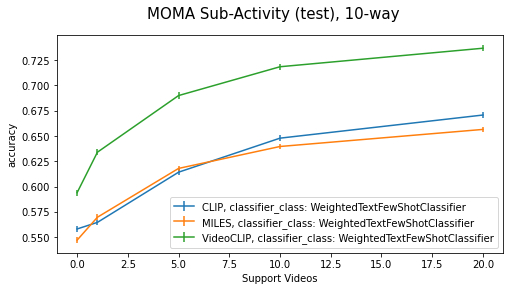

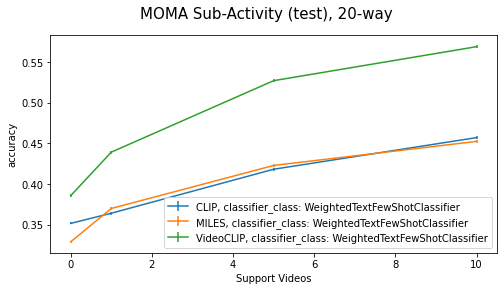

In [8]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way"],
    line_descriptor_cols=["vlm_class", "classifier_class"],
    agg_dict={
        "vlm.num_frames": max,
        "vlm.num_seconds": max,
        "vlm.sample_strat": max,
        "classifier.metric": max,
        "classifier.text_weight": max,
        "classifier.prompt_text": max,
        "classifier.neighbor_count": max,
        "classifier.neighbor_weights": max
    },
    filter_dict={},
    show_error_bars=True
)

63 Overall Lines
7 Separate Plots


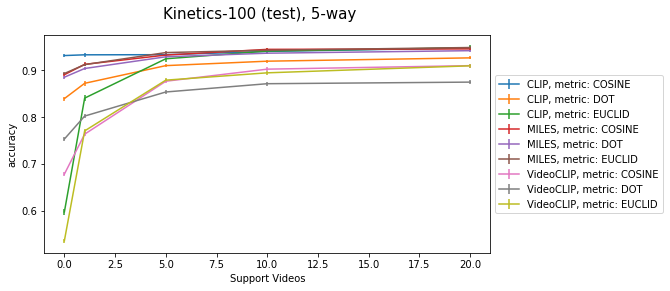

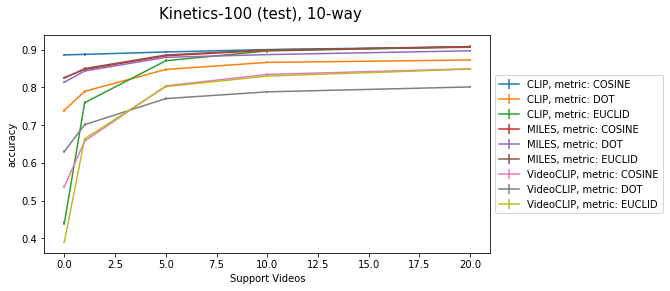

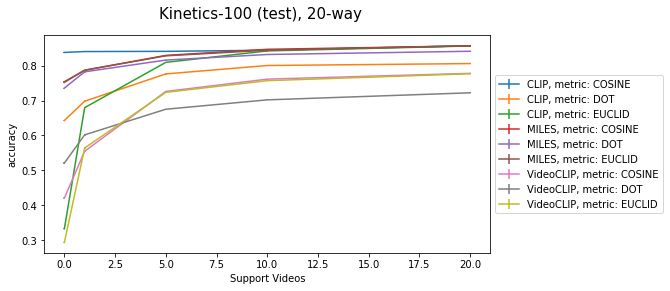

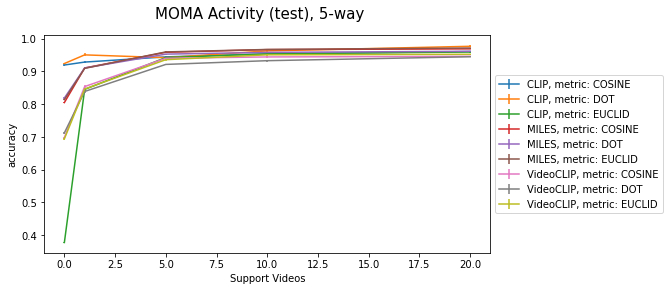

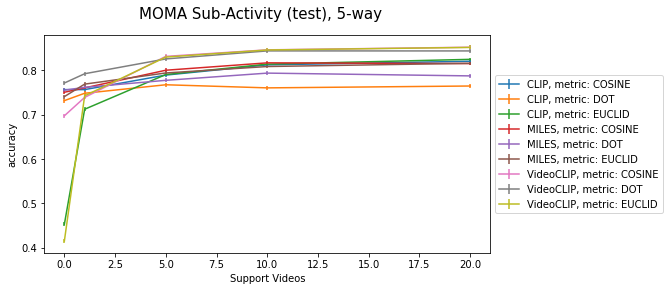

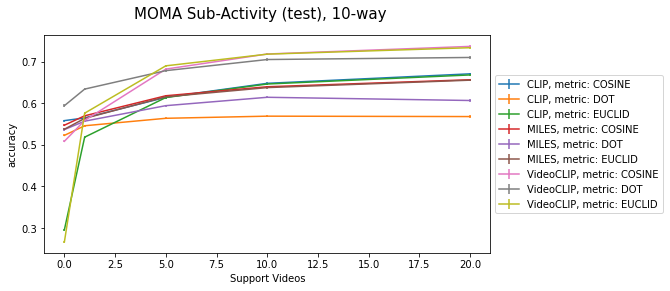

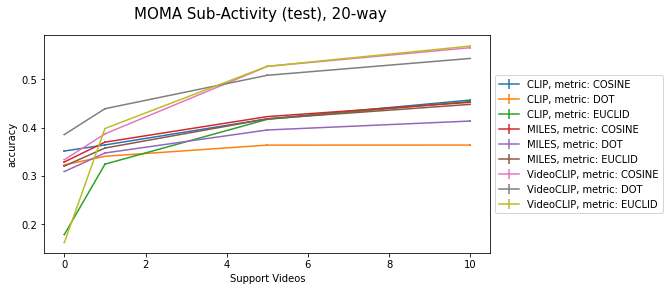

In [9]:
plot(
    test_handler.results,
    x_col="n_support",
    y_col="accuracy",
    plot_descriptor_cols=["dataset", "n_way"],
    line_descriptor_cols=["vlm_class", "classifier.metric"],
    agg_dict={
        "vlm.num_frames": max,
        "vlm.num_seconds": max,
        "vlm.sample_strat": max,
        "classifier.text_weight": max
    },
    filter_dict={
        "classifier_class": "WeightedTextFewShotClassifier"
    },
    show_error_bars=True
)